# HW4: Large Language Models

In this assignment, you will be implementing language models for next token prediction and generation of Shakespeare! This assignment will be in two parts. **For this final assignment, you have the option to work in pairs.**

**Part 1:**

In this part, you will review some key ingredients of sequence modeling. In the process, you will build a baseline transformer model for next token prediction trained on Shakespeare's works. We have provided the scaffolding for the code in this part of the assignment, and your task will be to fill in the key implementation steps.

**Part 2:**

This part is an open-ended mini-project where you have the freedom to try sequence modeling approaches of your choice on this problem. You should feel free to try other architectures (HMMs, RNNs, transformers, state space layers, diffusion models etc.) or to invent new architectures. You may also experiment with new algorithms for fitting or training these models. The goal will be to find some area of possible improvement (we interpret "improvement" quite loosely, but it is up to you to state precisely why your proposed innovation might constitute an improvement and to show convincing evidence that your innovation does or does not); to formulate and state a precise hypothesis; and to falsify or support the hypothesis with rigorous empirical analyses.

**Deliverables:**

- Code for Parts 1 of the assignment
- A written report of at most 4 pages for Part 2 (references not included in the page limit), with a link to code for Part 2. 

_Note: the code for Part 2 will not be graded, but we ask you to include a link to it for completeness._

**Important: Choosing runtimes**

Google Colab has limits on the free usage of GPU runtimes. For this assignment, **we strongly recommend doing the majority of your prototyping, testing, and small-scale experiments on CPU backend**. Then, once you are ready to train your models, you should switch to a T4 GPU.

You can change runtime type by clicking **Runtime -> Change Runtime Type** in the tabs above. You can monitor your resource usages in the top right corner of the screen (it should say what backend you are using, how many compute units per hour you are using, etc.)

**Make sure to turn off GPU runtime if you are not actively using it!**






## Setup

In [1]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm

import requests
import os

torch.manual_seed(305)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'

We set default values for some global hyperparameters, but feel free to change these during development as needed.

In [2]:
# Global hyperparameters
SMALL_ITERS = 1000
LARGE_ITERS = 2000
EVAL_ITERS = 100
CONTEXT_WINDOW_SIZE = 256

## Part 0: Preprocessing

As in the previous problem sets, a certain amount of preprocessing for textual data is required.

### 0.1: Loading and preprocessing the dataset


The first step is to download the dataset. We will be using a dataset from Andrej Karpathy consisting of a subset of works from Shakespeare.

The dominant mode for preprocessing textual data is to tokenize it; that is, to split the dataset into a finite vocabulary of tokens. Then, we can set up a dictionaries mapping from counting numbers (representing tokens) to tokens and vice versa. Tokens can be characters, or words, or subwords; in fact, the "best" way to tokenize text is an active area of research.

To keep things simple, we'll tokenize the text on a per-character level.

In [3]:
# download the tiny shakespeare dataset
input_file_path = 'input.txt'

if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 1,115,394


In [4]:
# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65


In [5]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
train_chars = data[:int(n*0.9)]
val_chars = data[int(n*0.9):]

# encode both to integers
train_data = encode(train_chars)
val_data = encode(val_chars)

# cast as torch tensors
train_data = torch.tensor(train_data)
val_data = torch.tensor(val_data)

print(f"train has {len(train_data):,} tokens")
print(f"val has {len(val_data):,} tokens")

train has 1,003,854 tokens
val has 111,540 tokens


We also write helper functions to get batches of data and to evaluate the loss of various models on them.

In [6]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, context_window_size, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

## Part 1: Language Modeling

In this first part of the assignment, we will implement a baseline for code modeling.

In the process of building this baseline, we will review 4 key ideas of sequence modeling that have become the backbone of modern language models such as ChatGPT:

1. Framing language modeling as next token prediction, and next token prediction as multiclass logistic regression
2. Embedding discrete tokens in continuous latent spaces (word embeddings)
3. Use the attention mechanism to move beyond Markovian models for sequences (we of course pay for this greater expressivity with increased compute, which is made possible in part by using matrix multiplications on hardware accelerators like GPUs. Reducing the compute burden while maintaining the expressivity needed for good sequence modeling is an active area of research).
4. Combining attention with deep learning in the Transformer architecture.

### 1.1: Next token prediction as multiclass logistic regression

Our first language model will simply be a lookup table. That is, given that we have token with value $v$, we will simply "look up" the logits that correspond to our prediction for the next token. This model is often known as a "bigram model" because it can be derived from the relative proportions of different bigrams (ordered pairs of tokens) occurring in a large text corpus.

Let us be a bit more precise in our definition of the bigram model. Let's say that the total size of our vocabulary (the number of tokens we are using) is $V$. Let $A$ be a matrix in $\mathbb{R}^{V \times V}$, where each row $A_v$ corresponds to the logits for the prediction of which token would follow a token that has value $v$.
Thus, we are modeling the distribution of the token following a token that has value $v$ as
\begin{align*}
y_{t+1} \mid y_t &= v \sim \mathrm{Cat}(\mathbf{\pi}) \\
\pi &=\mathrm{softmax}(A_v)
\end{align*}

#### Question 1.1.1

$\mathbf{\pi} \in \Delta_{V-1}$ is the vector of probabilities used to parameterize the categorical distribution for the next token prediction. Explain why we parameterize
\begin{equation*}
  \mathbf{\pi} = \mathrm{softmax}(A_v),
\end{equation*}
and could not just use
\begin{equation*}
  \mathbf{\pi} = A_v.
\end{equation*}

---

Because we want the probabilities of picking each class which the softmax function gives us.

---

#### Question 1.1.2

Discuss the relationship between the bigram model and contigency tables (discussed in Lecture 1).

---

The bigram model is related to the contingency tables discussed in Lecture 1 because the model forms a V x V table where each row corresponds to the transition probabilities from a given token to each of the other tokens. As these are conditional probabilities, we can multiply each entry by the sum of the entries in corresponding row (marginal probability) to get the joint probability.

---

#### Question 1.1.3

Say I have a string of three tokens with ids $(7, 3, 6)$. If I use the bigram model as a generative model for language, given this information, what is distribution of the fourth token? Write your answer in terms of the matrix $A$ we defined in 1.1

---


Assuming there are $V$ possible tokens, we can write the distribution of the next token as the conditional distribution given the most recent token, 6 (Markov Property).

Define each entry $A_{ij}$ as the logit for the prediction from token $i$ to token $j$. Therefore,

\begin{align*}
\pi &= \frac{1}{\sum_{j=1}^V \exp(A_{6j})} \bigg(\exp(A_{61}), \exp(A_{62}), \ldots, \exp(A_{6V}) \bigg) \\
\end{align*}

Where each entry in $\pi$ is represents the probability of choosing token $j$ from token 6. Thus, the distribution of the fourth token is a categorical distribution where each probability is given by the respective entry in $\pi$.


---

#### Question 1.1.4

Remember back in Part 0 when we gave you the helper function `get_batch`? Run `get_batch` and look at the inputs `x` and the targets `y`. Explain any relation between them in the context of formulating language modeling in the context of next token prediction.

In [7]:
xb, yb = get_batch('train', 10, device, batch_size = 1)
print(f"the features have token ids {xb}")
print('\n')
print(f"the targets have token ids {yb}")

the features have token ids tensor([[47, 53, 59, 57,  1, 50, 53, 60, 43,  6]], device='mps:0')


the targets have token ids tensor([[53, 59, 57,  1, 50, 53, 60, 43,  6,  0]], device='mps:0')


---

The features are one token behind the targets, as the features will be used to train the models based on the values of the targets. In other words, the target tokens are the same sequence as the features tokens but shifted one token to the right. This is important in the context of formulating language modeling because the model will learn to predict the next token (target) based on the current token (feature).


---

#### Question 1.1.5

Discuss the strengths and weaknesses of the bigram model as a generative model for language.

---

Strengths:

The bigram model is computationally inexpensive, easy to understand, and works well on small sequences to capture shorter dependencies between words.

Weaknesses:

The model's predictions are only based on the last token, which may not be relevant for language modeling since certain words and linguistic structures are based upon more than just one previous token. Furthermore, it is susceptible to data sparsity as the vocabulary increases, leading to potential computational challenges as the number of bigram pairs increases. Finally, the bigram model suffers with out-of-vocabulary words that are not used in training.

---

#### Question 1.1.6

Say I have a string $s$ of length $T$. Derive the formula for the negative log likelihood of $s$ under the bigram model in terms of the matrix of logits $A$. What would your answer be if the matrix of logits $A$ were all zeros? What would be the value of the negative log likelihood of $s$ under a model that always perfectly predicted the next token?

---

Begin with the definition of the likelihood of $s$:

\begin{align*}
P(s) &= \prod_{t=t}^T P(S_t | S_{t-1}) \\
\end{align*}

Where:

\begin{align*}
P(S_t | S_{t-1}) &= \frac{\exp(A_{S_{t-1},S_t})}{\sum_{j=1}^{V} \exp(A_{S_{t-1},j})} \\
\end{align*}

Thus:

\begin{align*}
P(s) &= \prod_{t=2}^T \frac{\exp(A_{S_{t-1},S_t})}{\sum_{j=1}^{V} \exp(A_{S_{t-1},j})} \\
\end{align*}

However, since we are aiming for the negative log likelihood, we want:

\begin{align*}
\log{P(s)} &= \sum_{t=2}^T \log{\frac{\exp(A_{S_{t-1},S_t})}{\sum_{j=1}^{V} \exp(A_{S_{t-1},j})}} \\
\log{P(s)} &= \sum_{t=2}^T \bigg( A_{S_{t-1},S_t} - \log{\sum_{j=1}^{V} \exp(A_{S_{t-1},j})} \bigg) \\
\end{align*}

Finally:

\begin{align*}
- \log{P(s)} &= - \sum_{t=2}^T \bigg( A_{S_{t-1},S_t} - \log{\sum_{j=1}^{V} \exp(A_{S_{t-1},j})} \bigg) \\
\end{align*}

If the matrix of logits is all 0s, we would expect every A term in the above formula to be 0, and thus:

\begin{align*}
-\log{P(s)} &= -\sum_{t=2}^T \bigg( 0- \log{\sum_{j=1}^{V} \exp(0)} \bigg) \\
-\log{P(s)} &= -\sum_{t=2}^T \bigg( 0- \log{\sum_{j=1}^{V} 1} \bigg) \\
-\log{P(s)} &= -\sum_{t=2}^T \bigg(-\log{V} \bigg) \\
-\log{P(s)} &= (T-1)\log{V} \\
\end{align*}

Thus, if the logits are all 0, then the negative log likelihood is proportional to the length of the sequence and the log of the vocabulary.

However, if all predictions are perfect, then we know that the value of $A_{S_{t-1},S_t}$ must be significantly larger than all $A_{S_{t-1},j}$ for $j \in [1,V]$. Thus, we surmise $\sum_{j=1}^{V} \exp(A_{S_{t-1},j}) \approx \exp(A_{S_{t-1},S_t})$. Using this result, we get:

\begin{align*}
- \log{P(s)} &= - \sum_{t=2}^T \bigg( A_{S_{t-1},S_t} - \log{\exp(A_{S_{t-1},S_t})} \bigg) \\
- \log{P(s)} &= - \sum_{t=2}^T \bigg( A_{S_{t-1},S_t} - A_{S_{t-1},S_t} \bigg) \\
- \log{P(s)} &= 0 \\
\end{align*}

Implying that the negative log likelihood is 0 when the model perfectly predicts the next token.

---

#### Question 1.1.7: Implement the BigramLanguageModel

Implement the bigram language model below.

Your TODOs:
  * if the `forward` method is provided a target, the loss should be the negative log likelihood of the target (given the context)
  * `generate` should take in (batched) contexts and a number of new tokens to generate, and then generate text autoregressively from your model. Note that in autoregressive text generation, you iteratively append the tokens you generate to your context.


In [8]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        """
        Args:
          vocab_size: size of the vocabulary (the number of tokens)
        """
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.logits_table = nn.Embedding(vocab_size, vocab_size)
        self.vocab_size = vocab_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: Int(B, T), token ids that make up the context (batch has size B, each entry in the batch has length T)
          targets: Int(B, T), token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t, :] gives the length V vector of logits for the next token prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """

        # idx and targets are both (B,T) tensor of integers
        logits = self.logits_table(token_ids) # (B,T,V)

        if targets is None:
            loss = None
        else:
            # TODO: what should the loss in this setting be?
            loss = F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1))

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens=CONTEXT_WINDOW_SIZE):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        B, T = token_ids.shape
        new_token_ids = token_ids.clone()
        for t in range(max_new_tokens):
            logits = self.logits_table(new_token_ids)
            new_token = torch.multinomial(F.softmax(logits[:, -1, :], dim=-1), 1)
            new_token_ids = torch.cat([new_token_ids, new_token], dim=1)
        return new_token_ids


#### Question 1.1.8: Evaluating the initialization.

Evaluate the loss of your untrained bigram model on a batch of data. Make sure the loss (negative log likelihood) is per-token (i.e. you may need to average over both sequence length and batch). Does this loss make sense in the context of your answer to Question 1.1.6? Discuss.

In [9]:
x,y = get_batch("train", CONTEXT_WINDOW_SIZE, device)
bigram_model = BigramLanguageModel(vocab_size)
bm = bigram_model.to(device)

# TODO: your code below
logits, loss = bm(x, y)
print(f"loss: {loss:.2f}")

loss: 4.66


---

From our answer in Q1.1.6, we know that a model with logits = 0 has a loss equivalent to $(T-1)\log{V}$. Per token, this would be approximately equal to $\log{V} = \log{65} \approx 4.17$. However, since we initialized the model with random logits, we would expect our loss to be similar to a model with initialized logits of 0 since the model has not received any training on the data itself. Furthermore, having a loss larger than the theoretical value where all the logits are 0 is not unexpected since the assumption of uniform prediction over the vocabulary may be better than a completely random assignment for the logits.

---

#### Question 1.1.9: Training your bigram model

Train your bigram model for `SMALL_ITERS` iterations. Plot and interpret the loss curve.

Our train loss gets down to around 2.5 after 1000 iterations.

In [10]:
# create a PyTorch optimizer
learning_rate = 1e-2
optimizer = torch.optim.AdamW(bigram_model.parameters(), lr=learning_rate)

eval_interval = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(bm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
        print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = bm(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 4.6454, val loss 4.6532


 20%|██        | 201/1000 [00:00<00:02, 328.48it/s]

iteration 200
step 200: train loss 2.8995, val loss 2.9157


 42%|████▎     | 425/1000 [00:01<00:01, 408.90it/s]

iteration 400
step 400: train loss 2.5581, val loss 2.5770


 59%|█████▉    | 591/1000 [00:01<00:00, 574.95it/s]

iteration 600
step 600: train loss 2.4962, val loss 2.5211


 80%|████████  | 801/1000 [00:01<00:00, 423.09it/s]

iteration 800
step 800: train loss 2.4797, val loss 2.5081


100%|██████████| 1000/1000 [00:02<00:00, 436.61it/s]

iteration 999
step 999: train loss 2.4728, val loss 2.5016


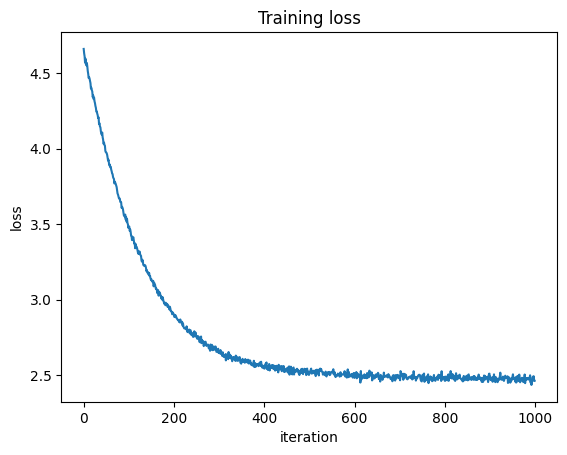

In [11]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Training loss")
plt.show()

---

From the plot above,we can see the loss curve is monotonically decreasing with iterations. However, the rate of decrease slows considerably by the 400-iteration mark. The loss begins around 4.7 and decreases to a value of approximately 2.5, which aligns with adjacent results.

---

Note that these models can take up a lot of memory on the GPU. As you go through this assignment, you may want to free the models after you train them using code along the lines of
```
model.to('cpu')
torch.cuda.empty_cache()
```

### 1.2: Token Embeddings: going from discrete tokens to continuous latent spaces

In the look up table formulation of the bigram model, we are modelling the logits of the next token distribution independently for each token, even if two tokens are extremely similar to each other.
One way around this problem is to learn an embedding of the discrete tokens into $\mathbb{R}^{D}$, and then to run multi-class logistic regression on top of this learned embedding.

More precisely, if we have a vocabulary of tokens of size $V$ that we choose to embed in a Euclidean embedding space of dimension $D$, we can parameterize the distribution of the next token if the current token is $v$ according to
\begin{align*}
  \mathrm{Cat}\Big( \mathrm{softmax} (\beta X_v) \Big),
\end{align*}
where $X_v \in \mathbb{R}^{D}$ is the learned embedding of token $v$ into $\mathbb{R}^{D}$ and $\beta \in \mathbb{R}^{V \times D}$. Notice that if $X$ were a fixed design matrix this formulation would be equivalent to multi-class logistic regression. However, both $X$ and $\beta$ are learnable parameters.

#### Question 1.2.1: Implement BigramWithWordEmbeddingsLM

Implement a bigram languge model that uses a linear readout from a low dimensional Euclidean embedding of each token to parameterize the logits of the next token distribution, instead of parameterizing the logits of the next token distribution directly. It should have almost the same implementation as `BigramLanguageModel` from Question 1.1.6, except `init` should also take in an `embed_size`, and the `forward` method will need to be modified.

In [12]:
class BigramWithWordEmbeddingsLM(nn.Module):

    def __init__(self, vocab_size, embed_size=32):
      """
      Args:
        vocab_size: int, size of the vocabulary
        embed_size: int, dimension of the word embedding (D)
      """
      super().__init__()
      #TODO, your code here
      self.vocab_size = vocab_size
      self.embed_size = embed_size
      self.logits_table = nn.Linear(embed_size, vocab_size)
      self.word_embeddings = nn.Embedding(vocab_size, embed_size)
      pass

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t, :] gives the length V vector of logits for the next token prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO, your code here

        logits = None
        loss = None

        logits = self.logits_table(self.word_embeddings(token_ids))
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1))

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens=CONTEXT_WINDOW_SIZE):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below

        B, T = token_ids.shape
        new_token_ids = token_ids.clone()
        for t in range(max_new_tokens):
            logits = self.logits_table(self.word_embeddings(new_token_ids))
            new_token = torch.multinomial(F.softmax(logits[:, -1, :], dim=-1), 1)
            new_token_ids = torch.cat([new_token_ids, new_token], dim=1)
        return new_token_ids


#### Question 1.2.2: Training your bigram model with word embeddings

Train your bigram model with word embeddings for `SMALL_ITERS` iterations. Plot and interpret the loss curve. How does the final loss compare to that of the bigram model without embeddings? Why do you think this is?

Our train loss gets down to around 2.5 after 1000 iterations.

In [13]:
bigram_model_embed = BigramWithWordEmbeddingsLM(vocab_size)
bm_e = bigram_model_embed.to(device)

learning_rate = 1e-2
optimizer = torch.optim.AdamW(bigram_model_embed.parameters(), lr=learning_rate)

eval_interval = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(bm_e, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
        print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = bm_e(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0


  5%|▌         | 54/1000 [00:00<00:04, 192.67it/s]

step 0: train loss 4.3316, val loss 4.3335


 22%|██▏       | 224/1000 [00:00<00:02, 303.75it/s]

iteration 200
step 200: train loss 2.4721, val loss 2.4930


 38%|███▊      | 375/1000 [00:01<00:01, 376.69it/s]

iteration 400
step 400: train loss 2.4644, val loss 2.4947


 58%|█████▊    | 582/1000 [00:01<00:00, 432.35it/s]

iteration 600
step 600: train loss 2.4620, val loss 2.4883


 80%|████████  | 801/1000 [00:02<00:00, 339.08it/s]

iteration 800
step 800: train loss 2.4595, val loss 2.4935


100%|██████████| 1000/1000 [00:02<00:00, 345.25it/s]

iteration 999
step 999: train loss 2.4584, val loss 2.4927


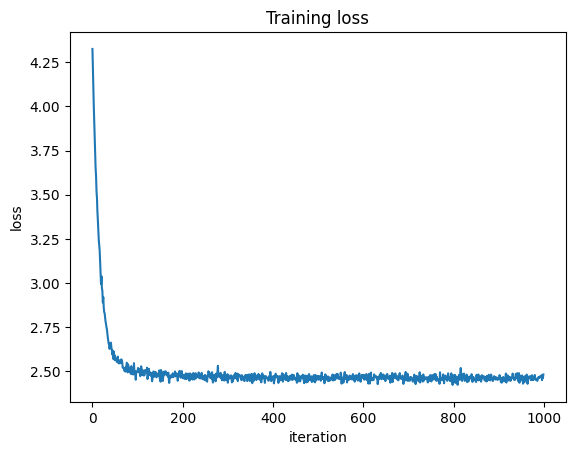

In [15]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Training loss")
plt.show()

---

From the plot above, we can see the model begins at a similar loss value and ends at a very similar loss value to the bigram model without embeddings. However, it reaches this loss value much quicker (approximately 100 iterations).

We note that the loss values are similar because of they are fundamentally performing the same task. They both use the current token to predict the next token (Markov property). The only difference between these models is that one will use a lookup table of size $V \times V$ whereas the other will use a $V \times D$ embedding matrix and a $D \times V$ projection matrix. Since they both utilize similar methods to predict the next token, the overall loss result is expected to be similar.

---

### 1.3: Attention: Relaxing Markovian assumptions to transmit information across the sequence length

A major problem with the bigram models of Sections 1.1 and 1.2 was that they were Markovian: the distribution of the next token was determined entirely by the current token! The attention mechanism provides a way to extract information between the previous tokens in the context to provide a better parameterization for the distribution of the next token.

#### Question 1.3.1: Averaging over word embeddings

One simple way to pool information would simply be to average the embeddings!

Your TODO: Add comments to the the code snippet below. Write a description here explaining why the code is mathematically equivalent to averaging the embeddings of the previous tokens and the current token.

---

The code is mathematically equivalent to averaging the embeddings of the previous and current tokens because of softmax and the random initialization of 0 for the attn_weights. Since the softmax function is applied to each row of the attn_weights, we know that the row dimension will be normalized based on number of embeddings that have been seen. Thus, multiplying this by the word embeddings creates a weighted sum of each of the embeddings weighted the total number of embeddings that have come before it (and including it). This can be seen in the final output, as the first two entries are unchanged, but the rest of the values are weighted sums of the values before and up to the current embedding.

---

In [17]:
# average word embedding via matrix multiply and softmax
small_batch_size = 4              # B
small_context_window_size = 8     # T
small_embed_size = 2              # D

# make "synthetic" word embeddings (for illustration purposes only)
X = torch.randn(small_batch_size, small_context_window_size, small_embed_size)

# X is a sample small batch of size B. Each sample has a context window of size T and each word is represented by a D-dimensional embedding.
print(X.shape)

# tril is a lower triangular matrix of size T x T. This is the attention mask that ensures the model only looks at things we've seen already.
tril = torch.tril(torch.ones(small_context_window_size, small_context_window_size))

# attn_weights is a matrix of size T x T. This is the attention weights that will be used to compute the weighted average of the embeddings.
attn_weights = torch.zeros((small_context_window_size, small_context_window_size))

# fill in the attention weights using the lower triangular mask. For values we haven't seen yet, we set the attention weight to -inf which will go to 0 after softmax.
attn_weights = attn_weights.masked_fill(tril == 0, float('-inf'))

# softmax the attention weights. Weights will sum to 1 with values evenly distributed among the words we've seen.
attn_weights = F.softmax(attn_weights, dim=-1)

# Multiplying the attention weights by the embeddings will give us the weighted average of the embeddings.
avg_embeddings = attn_weights @ X

print(X[0])
print("")
print(avg_embeddings[0])

torch.Size([4, 8, 2])
tensor([[ 0.5318, -0.4167],
        [-0.4982,  0.0156],
        [ 1.1415, -0.1181],
        [ 0.2128,  2.3295],
        [ 0.4573,  0.7488],
        [ 0.3794, -0.2672],
        [-1.2237,  2.7066],
        [ 0.5399, -0.5297]])

tensor([[ 0.5318, -0.4167],
        [ 0.0168, -0.2006],
        [ 0.3917, -0.1731],
        [ 0.3470,  0.4525],
        [ 0.3690,  0.5118],
        [ 0.3708,  0.3820],
        [ 0.1430,  0.7140],
        [ 0.1926,  0.5586]])


#### 1.3.2: Single-headed scaled $(Q,K,V)$-attention

A more sophisticated approach than simply averaging over previous word embeddings is single-headed (Query, Key, Value) scaled attention.
That is, we now summarize the information contained in a length $T$ sequence of tokens that have been embeded into $X \in \mathbb{R}^{T \times D}$ according to
\begin{equation}
   \mathrm{SoftmaxAcrossRows} \Bigg( \frac{\mathrm{CausalMask}\Big(X U_q^\top U_k X^\top \Big)}{\sqrt{K}} \Bigg) \Big( X V^\top \Big),
\end{equation}
where $U_q, U_k \in \mathbb{R}^{K \times D}$, $V \in \mathbb{R}^{D \times D}$, and $K$ is the "head size".



##### Question 1.3.2.1

In the limiting case where $U_q$ and $U_k$ are all zeros, and $V = I_{D}$, what does $(U_q, U_k, V)$ attention simplify to?

---
In the following equation,

\begin{equation}
   \mathrm{SoftmaxAcrossRows} \Bigg( \frac{\mathrm{CausalMask}\Big(X U_q^\top U_k X^\top \Big)}{\sqrt{K}} \Bigg) \Big( X V^\top \Big),
\end{equation}

If $U_q$ and $U_k$ are all zeros, then:

\begin{equation}
   \mathrm{SoftmaxAcrossRows} \Bigg( \frac{0}{\sqrt{K}} \Bigg) \Big( X V^\top \Big),
\end{equation}

Which is equivalent to

\begin{equation}
   \mathrm{SoftmaxAcrossRows} \Big( 0 \Big) \Big( X V^\top \Big),
\end{equation}

If $V = I_{D}$, then

\begin{equation}
   \mathrm{SoftmaxAcrossRows} \Big( 0 \Big) \Big( X\Big),
\end{equation}

But from Q1.3.1, we know that the softmax of the 0 matrix is the attn_weights from Q1.3.1, and thus we get the same thing we had before.

---

##### Question 1.3.2.2: Implement single-headed scaled $(U_q,U_k,V)$-attention.

Complete the below code so the `forward` method returns single-headed scaled $(U_q,U_k,V)$-attention.

In [18]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        # TODO: your code here
        B, T, _ = x.shape
        K = self.head_size
        key = self.key(x)
        query = self.query(x)
        value = self.value(x)

        attn_scores = query@key.transpose(-2, -1)
        causal_mask = self.tril[:T, :T][None, :, :]
        attn_scores = attn_scores.masked_fill(causal_mask == 0, float('-inf'))
        attn_weights = torch.softmax(attn_scores / (K ** 0.5), dim=-1)
        return attn_weights@value

##### Question 1.3.2.3: Implement a single-headed attention language model

Complete the code below. Note that because the transformer has no idea where tokens are occuring in space, we have also added in position embeddings.

In [19]:
class SingleHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, head_size, embed_size=384):
      """
      Args:
        vocab_size: int, size of the vocabulary (V)
        context_window_size: int, number of tokens considered in the past for attention (T)
        head_size: int, size of the head embedding dimension (K)
        embed_size: int, size of the token embedding dimension (D)
      """
      super().__init__()
      self.vocab_size = vocab_size
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.context_window_size = context_window_size

      # TODO: your code below
      self.atten_head = Head(head_size, context_window_size, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry
                     in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V) logits[b,t] gives the length V vector of logits for the next token
                   prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        B, T = token_ids.shape # (batch size, length)
        tok_emb = self.token_embedding_table(token_ids) # (B,T,D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,D)
        x = tok_emb + pos_emb # (B,T,D)
        x = self.atten_head(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,V)

        # TODO: your code here
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1))

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below
        B, T = token_ids.shape
        new_token_ids = token_ids.clone()
        for t in range(max_new_tokens):
            logits = self(new_token_ids)
            new_token = torch.multinomial(F.softmax(logits[:, -1, :], dim=-1), 1)
            new_token_ids = torch.cat([new_token_ids, new_token], dim=1)
        return new_token_ids

Train your new `SingleHeadedAttentionLM` for `SMALL_ITERS` training iterations and plot the loss curve.
The `head_size` shouldn't matter too much, we just use the `embedding_size`.
Do you seen an improvement compared to your `BigramLanguageModel`? Discuss.

Note: you may want to modify the learning rate. Training for `SMALL_ITERS` with a learning rate of `6e-4`, we can get to a train loss of around 2.3.

In [20]:
embed_size = 384
sha_model = SingleHeadedAttentionLM(vocab_size, CONTEXT_WINDOW_SIZE, embed_size, embed_size)
sham = sha_model.to(device)
learning_rate = 6e-4
optimizer = torch.optim.AdamW(sha_model.parameters(), lr=learning_rate)

eval_interval = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(sham, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
        print(
            f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb = get_batch("train", CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = sham(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0


  1%|          | 12/1000 [00:00<01:00, 16.26it/s]

step 0: train loss 4.1927, val loss 4.1915


 19%|█▉        | 191/1000 [00:02<00:08, 99.40it/s]

iteration 200


 21%|██        | 212/1000 [00:03<00:20, 39.35it/s]

step 200: train loss 2.5919, val loss 2.5996


 39%|███▉      | 392/1000 [00:05<00:06, 99.38it/s]

iteration 400


 41%|████▏     | 413/1000 [00:06<00:14, 40.08it/s]

step 400: train loss 2.5403, val loss 2.5580


 59%|█████▉    | 590/1000 [00:08<00:04, 99.95it/s]

iteration 600


 61%|██████    | 612/1000 [00:09<00:09, 40.78it/s]

step 600: train loss 2.4720, val loss 2.4958


 80%|███████▉  | 799/1000 [00:11<00:02, 99.59it/s] 

iteration 800


 82%|████████▏ | 819/1000 [00:12<00:04, 37.58it/s]

step 800: train loss 2.3846, val loss 2.4250


100%|█████████▉| 995/1000 [00:13<00:00, 100.65it/s]

iteration 999


100%|██████████| 1000/1000 [00:14<00:00, 67.94it/s]

step 999: train loss 2.3517, val loss 2.3903


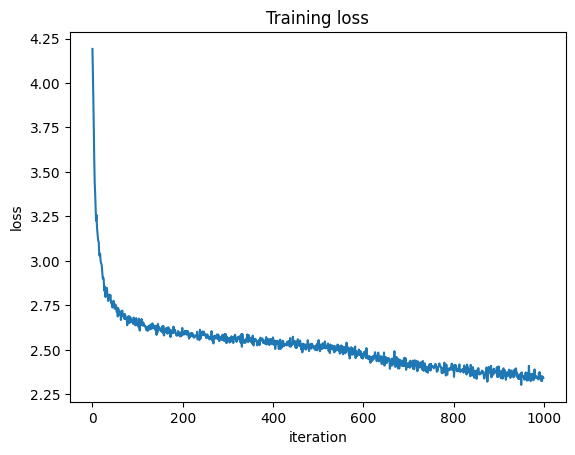

In [22]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Training loss")
plt.show()

---

From our results and plots from the bigram models, we can see that using a single head of attention is not a significant improvement over just the bigram model. We note that the final loss values are similar; however, the loss of the single headed attention model does not appear to slow as heavily as the bigram models. This could imply that more training time could lead to a better result, as attention may take much longer to refine. Finally, we note that with a single head of attention, the model may not be able to effectively capture complex relationships in Shakespeare's prose. With increasing model complexity, we may see even more improvements.

---

#### 1.3.3: Multi-headed attention

##### Question 1.3.3.1: Implement multi-headed attention

In [23]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, context_window_size, num_heads, head_size, embed_size=384):
        """
        Args:
            context_window_size: int, number of tokens considered in the past for attention (T)
            num_heads: int, number of heads (H)
            head_size: int, size of the head embedding dimension
            embed_size: int, size of the token embedding dimension
        """
        super().__init__()
        # TODO, your code below
        self.heads = nn.ModuleList([Head(head_size, context_window_size, embed_size) for _ in range(num_heads)])
        self.lm_head = nn.Linear(embed_size*num_heads, embed_size)
        self.num_heads = num_heads

    def forward(self, x):
        # TODO, your code below
        B, T, _ = x.shape
        head_size = x.shape[-1] // self.num_heads
        head_outputs = [head(x) for head in self.heads]
        head_outputs = torch.cat(head_outputs, dim=-1)
        head_outputs = head_outputs.view(B, T, -1)
        return self.lm_head(head_outputs)

##### Question 1.3.3.2: Implement a multi-headed attention LM

Fill in the code below to create a language model that outputs its logits for next token prediction using multi-headed attention. Train your model for `SMALL_ITERS` training iterations. Compare the results with the single-headed attention model. Do you see an improvement?

We get to a train loss of around 2 after 1000 iterations, which takes around 1.5 minutes on a T4 GPU.

In [24]:
class MultiHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
      super().__init__()
      self.head_size = embed_size // num_heads
      self.context_window_size = context_window_size
      # TODO: your code below
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.multi_head_attention = MultiHeadAttention(context_window_size, num_heads, self.head_size, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)
      self.vocab_size = vocab_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the
                     batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t] gives the length V vector of logits for the next token
                  prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO: your code below
        loss = None
        B, T = token_ids.shape
        tok_emb = self.token_embedding_table(token_ids)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.multi_head_attention(x)
        logits = self.lm_head(x)
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        for t in range(max_new_tokens):
            if token_ids.shape[1] > self.context_window_size:
                token_ids = token_ids[:, -self.context_window_size:]
            B, T = token_ids.shape
            logits, loss = self.forward(token_ids)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            new_token = torch.multinomial(probs, 1)
            token_ids = torch.cat([token_ids, new_token], dim=1)
        return token_ids
        


In [25]:
# Initialize model
model = MultiHeadedAttentionLM(vocab_size, CONTEXT_WINDOW_SIZE)
m = model.to(device)

# create a PyTorch optimizer
learning_rate = 6e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

eval_interval = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(m, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
        print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = m(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0


  0%|          | 5/1000 [00:02<07:03,  2.35it/s]

step 0: train loss 4.1585, val loss 4.1596


 20%|██        | 200/1000 [00:10<00:30, 25.90it/s]

iteration 200


 20%|██        | 203/1000 [00:13<03:57,  3.36it/s]

step 200: train loss 2.4435, val loss 2.4729


 40%|███▉      | 398/1000 [00:20<00:23, 26.11it/s]

iteration 400


 40%|████      | 404/1000 [00:23<02:10,  4.58it/s]

step 400: train loss 2.1948, val loss 2.2595


 60%|█████▉    | 599/1000 [00:30<00:15, 26.08it/s]

iteration 600


 60%|██████    | 605/1000 [00:33<01:26,  4.56it/s]

step 600: train loss 2.0513, val loss 2.1473


 80%|████████  | 800/1000 [00:41<00:07, 26.14it/s]

iteration 800


 80%|████████  | 803/1000 [00:43<00:58,  3.38it/s]

step 800: train loss 1.9827, val loss 2.1064


100%|█████████▉| 998/1000 [00:51<00:00, 25.88it/s]

iteration 999


100%|██████████| 1000/1000 [00:53<00:00, 18.54it/s]

step 999: train loss 1.9331, val loss 2.0736


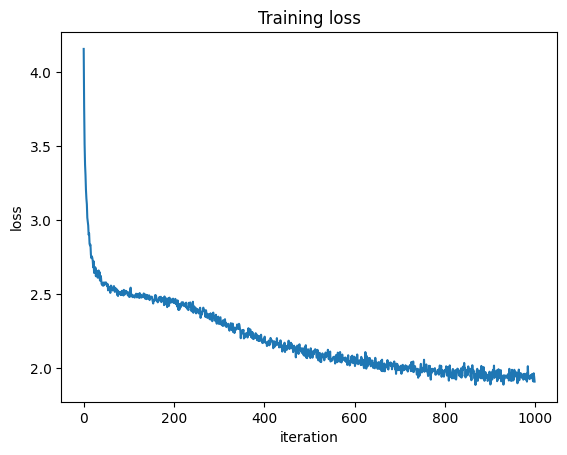

In [26]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Training loss")
plt.show()

---

Compared to the model with a single head of attention, we can see losses are noticeably smaller for the multi-headed attention model. This makes sense as a multi-headed attention model is better suited to capture numerous complex relationships between tokens, which is to be expected with text written by Shakespeare.

---

### 1.4: The Transformer Architecture: combining attention with deep learning

In [27]:
# run this cell to initialize this deep learning module that you should use in the code your write later
# you don't need to edit this layer
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )

    def forward(self, x):
        return self.net(x)

#### Question 1.4.1: Implement a transformer block

Complete the code below to implement a transformer block

To make the your implemenation easier to train, we have added two deep learning best practices:

1. Residual connections.

    In the `forward` method of the `TransformerBlock`, we have implemented a residual connection of the form
    
    \begin{align*}
    x \mapsto x + f(x)
    \end{align*}
    
    where $f$ is a nonlinear function. The idea is that every layer is some adjustment of the identity function, which guards against vanishing gradients in a deep network during back propogation, especially at initialization.

2. Prenorm via `LayerNorm`

    Also in the `forward` method of the `TransformerBlock`, the nonlinearity first applied a `LayerNorm` to its arguments. The `LayerNorm` basically standardizes the activations in that layer so that they have mean 0 and variance 1. Doing so is very helpful for numerical stability, espeically of the gradients.

In [28]:
class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size)
        self.atten_heads = MultiHeadAttention(context_window_size, num_heads, embed_size // num_heads, embed_size)

    def forward(self, x):
        x = x + self.atten_heads(self.ln1(x)) # communication over sequence length
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space
        return x

#### Question 1.4.2: Implement your baseline transformer model

We now stack 6 `TransformerBlocks` (with a final layer norm applied after the blocks but before the logits) to create our basline `TransformerLM`.

In [29]:
class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)])

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        # TODO: your code below
        loss = None
        logits = self.blocks(x)
        logits = self.ln_f(logits)
        logits = self.lm_head(logits)
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # TOOD, your code below
        self.eval()
        for _ in range(max_new_tokens):
            if token_ids.size(1) > CONTEXT_WINDOW_SIZE:
                token_ids = token_ids[:, -CONTEXT_WINDOW_SIZE:]
            logits, _ = self(token_ids)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1) 
            next_token = torch.multinomial(probs, num_samples=1)
            token_ids = torch.cat([token_ids, next_token], dim=1)
        self.train()
        return token_ids

Train your `TransformerLM` for `LARGE_ITERS` iterations and plot the loss curve. You may want to change the learning rate.

We used a learning rate of `1e-4` and got to a final train loss of around 1.4 in around 15 minutes of training on a T4 GPU.

In [30]:
trans = TransformerLM(vocab_size, CONTEXT_WINDOW_SIZE)
tlm = trans.to(device)
learning_rate = 1e-4
# TODO, your code below

optimizer = optim.Adam(tlm.parameters(), lr=learning_rate)

loss_list = []
eval_interval = 200
tlm.train()
for it in tqdm(range(LARGE_ITERS)):
    # Evaluate
    if it % eval_interval == 0:
        losses = estimate_loss(tlm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
        print(f"step {it}: train loss {losses['train']:.3f}, val loss {losses['val']:.3f}")
    
    # Forward/backward/update
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device, batch_size = 32)
    logits, loss = tlm(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())

print("final training loss =", loss_list[-1])


  0%|          | 0/2000 [00:00<?, ?it/s]

step 0: train loss 4.233, val loss 4.232


 10%|█         | 200/2000 [01:24<09:35,  3.13it/s] 

step 200: train loss 2.486, val loss 2.496


 20%|██        | 400/2000 [02:48<08:27,  3.15it/s]  

step 400: train loss 2.291, val loss 2.312


 30%|███       | 600/2000 [04:12<07:23,  3.15it/s]  

step 600: train loss 2.016, val loss 2.075


 40%|████      | 800/2000 [05:36<06:20,  3.15it/s]  

step 800: train loss 1.799, val loss 1.922


 50%|█████     | 1000/2000 [07:00<05:23,  3.09it/s] 

step 1000: train loss 1.671, val loss 1.823


 60%|██████    | 1200/2000 [08:25<04:17,  3.11it/s]  

step 1200: train loss 1.577, val loss 1.751


 70%|███████   | 1400/2000 [09:50<03:13,  3.10it/s]  

step 1400: train loss 1.502, val loss 1.705


 80%|████████  | 1600/2000 [11:15<02:10,  3.07it/s]  

step 1600: train loss 1.465, val loss 1.672


 90%|█████████ | 1800/2000 [12:39<01:03,  3.15it/s]

step 1800: train loss 1.420, val loss 1.628


100%|██████████| 2000/2000 [14:03<00:00,  2.37it/s]

final training loss = 1.380360722541809


In [39]:
losses

{'train': tensor(1.4201), 'val': tensor(1.6275)}

#### Question 1.4.3: Generating text!

Now with our trained model, we can generate some text that is somewhat like the style of Shakespeare! Below we will do both unconditional and conditional generation.

In [31]:
# unconditional generation from the model
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
uncond_gen = (tlm.generate(start_context, max_new_tokens=CONTEXT_WINDOW_SIZE)[0].tolist())
print(decode(uncond_gen))


Kecong and to her no heart,
Awaked, and my Crescy, declime, my betters'd
Upon mine to them.

DUCHESS OF YORK:
I knever duke a justague as great.

RICHARD:
This love to me neval it me.

DUKE OF AUMERLE:
Take it two cornsels to the discatch
Seemer I on think


In [32]:
# conditional generation from the model

context1 = """ROMEO:
He jests at scars that never felt a wound.
But, soft! what light through yonder window breaks?
It is the east, and Juliet is the sun.
Arise, fair sun, and kill the envious moon,
Who is already sick and pale with grief,
That thou her maid art far more fair than she:
Be not her maid, """

context1_tokens = torch.tensor(encode(context1), device=device).reshape(1, -1)

In [33]:
cond_gen = (tlm.generate(context1_tokens, max_new_tokens=CONTEXT_WINDOW_SIZE)[0].tolist())
print(decode(cond_gen))

 and wish may Romeo?
Beard loving arms so your on's sicre.

HERRMIONE:
Taken your short's royall about your armedly.

HENRY BOLINGOROKE:
By him, bruther, O, prince with his compats
To keep not down his not hath our in than yield,
But trikely which butwen th


TODO: Choose your own context from Shakespeare, and perform conditional generation from that text. Does this look reasonable to you? Why or why not?

In [35]:
# TODO: your code here

context2 = """To be, or not to be: """
context2_tokens = torch.tensor(encode(context2), device=device).reshape(1, -1)
cond_gen2 = (tlm.generate(context2_tokens, max_new_tokens=CONTEXT_WINDOW_SIZE)[0].tolist())
print(decode(cond_gen2))


 feor I chek you will think
every is far absence: and espute forth I
never have strong to rupp-speed. She donem, the
Liver ptock, and be doubteat to the ochactor: you
must havim, then you shall, I did you wind.

First HusdY:
Peace for him
Thrips with here: 


---

From the output above, we can see that it does not follow the traditional "To be or not to be" speech. However, we also note that some of the words are not formatted correctly (random capitalization) and many of them are not words featured in common or Shakspeare English. Therefore, this is not necessarily a reasonable representation of Shakespeare's prose. This is to be expected due to the highly unstructured and variable nature of Shakepeare's texts. Furthermore, there may not be enough data to train the model to understand the complex relationships between tokens.

---

#### Question 1.4.4

The negative log-likelihood (averaged per token) we have been using to train our models can be expressed as
\begin{equation*}
  L = -\frac{1}{T} \sum_{t = 1}^{T} \log p(s[t] | \text{context})
\end{equation*}
for some document $s$, where $s[t]$ is the $t$th token of the doc. The natural language processing (NLP) community often reports the quantity
\begin{equation*}
  \text{perplexity} = \exp(L).
\end{equation*}

Give an intuitive interpretation of what perplexity is. Why might it be a more intuitive or natual measure to report than negative log-likelihood? Does the reported perplexity of your trained `TransformerLM` model make sense in terms of samples it generates? (Be sure to distinguish betwen `train` and `validation` perplexity. Which of `train` and `val` perplexity is more helpful for understanding your generated samples? Why?). (*Hint: your answer to Question 1.1.6 may be helpful*).

---

An intuitive interpretation of perplexity is the amount of uncertainty when the model attempts to pick the next token in a sequence. In other words, it represents how "perplexed" the model is when predicting the next token. For example, if a model has a perplexity of 5, then it had to uniformly choose between 5 different options at each token generating step. Naturally, a lower perplexity implies better predictive power. Finally, we note that a perplexity = 1 is a perfect performance, as the model had only one choice when generating a new token, which corresponds to a loss of 0.

This is more intuitive than negative log-likelihood since NLL is on a logarithmic scale which contrasts with the linear (and hence more intuitive) scale of perplexity. Furthermore, we note that NLL does not have an easily interpretable meaning when compared to perplexity. Thus perplexity is more intuitive than NLL for reporting model performance.

From the output above, we can calculate the approximate train and validation perplexity as $exp(1.4) = 4.06$ and $exp(1.62) = 5.05$ respectively. We can utilize the interpretation above to conclude that the model had to choose between approximately 4 to 5 choices per token during a prediction task. Based on the samples generated, this makes sense as the samples do resemble Shakespeare's style but are not perfect recreations of either common English or Shakespeare English.

Between train and val perplexity, we note validation perplexity is more helpful because it is based on text that wasn't used to tune the model. In other words, it measure how well the model generalizes to new text or new situations, which is the ultimate goal with prediction models. From Q1.1.6, we know that if each prediction is perfect, then the NLL is 0 and thus perplexity is 1. Since the data was used to tune the model parameters, the train perplexity may be subject to some degree of memorization. Thus, it may tend to make near-perfect predictions, which would skew the perplexity towards 1.


---

## Part 2: Mini-Project

Quick recap: So far we have

1. Preprocessed the Shakespeare dataset by encoding individual characters into integer tokens.
2. Implemented single headed attention and then further generalized to multiheaded attention. We further combined multiheaded attention with deep learning to create the transformer architecture.
3. Trained our transformer and generated output that looks to be in the style of Shakespeare.

Up to this point, the performance of our simple language model has clearly made a lot of progress. We can see that our model has learned to generate text that is close to the style of Shakespeare, although there are still many quirks and room for improvement.

### Project Outline

Find some area of possible improvement.
We interpret "improvement" quite loosely, but please state precisely why your proposed innovation might improve the model, and provide evidence that it does (or does not!) improve.
For your idea, **formulate a hypothesis** for why this change should result in a better model. **Implement your changes** and **report any findings**.

_Notes_: As this assignment is being treated as a project, you should expect training to take longer than previous assignments. However, please use your judgement to decide what is reasonable. We will not expect you to run training procedures that take more than 2 hours on the free Google Colab computing resources and we certainly do not expect you to acquire additional compute. The proposed improvements should not solely rely on increased computing demands.

_Hints_: There are many aspects to assessing a model. For example, not only is quality of generated text important, it is also of interest to reduce costs associated with training.

### Deliverables

In addition to a pdf of your python notebook, the submission for this project will be a written report no more than 4 pages in length using the [NeurIPS LaTex template](https://neurips.cc/Conferences/2023/PaperInformation/StyleFiles). Your report should include detailed analysis of the hypotheses you chose to test along with any conclusions.

The page limit for the report does not include bibliography or appendices. Make sure to keep the "ready for submission" option to help us grade anonymously. Your writeup should also contain a link to any code used to generate the project so that we can reference it while grading (Google Drive folder with colab notebooks or Github repo are both fine). You should have at least one plot in your main text (which is capped at 4 pages).

## Submission Instructions

You will generate two PDFs: one from Part 1, which involves completing this Colab to create a transformer baseline; and one from the mini-project in Part 2, which will be your write-up of no longer than 4 pages. Be sure to include a link to your code for Part 2 somewhere in your writeup.

**Combine the two PDFs into a single PDF and submit on gradescope. Tag your PDF correctly.**

If you work in a group of two, submit one assignment on gradescope and tag your group members. If you complete the assignment individually, submit as usual.